# Pips and Connection 

In [1]:
%pip install mongoengine
%pip install pycoshark
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
from mongoengine import connect
from pycoshark.mongomodels import Project, VCSSystem, Commit, FileAction, Hunk, Refactoring, IssueSystem, Issue, IssueComment, MailingList, Message
from pycoshark.utils import create_mongodb_uri_string
from mongoengine.connection import disconnect

# You may have to update this dict to match your DB credentials
credentials = {'db_user': '',
               'db_password': '',
               'db_hostname': 'localhost',
               'db_port': 27017,
               'db_authentication_database': '',
               'db_ssl_enabled': False}

uri = create_mongodb_uri_string(**credentials)

# disconnect(alias='default')
connect('smartshark_2_1', host=uri, alias='default')

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary())

# Analise

In [3]:
projectsList = ['archiva', 'commons-math', 'ant-ivy', 'kafka','zeppelin','mahout','struts','wss4j','xerces2-j','jspwiki']
smallInfos = {}
fullInfos = {}
infoCommit = {}

for p in projectsList:
    project = Project.objects(name=p).get()

    vcs_system = VCSSystem.objects(project_id=project.id).get()

    print('VCS System:', vcs_system.url)

    num_commits = Commit.objects(vcs_system_id=vcs_system.id).count()

    print('Number of commits:', num_commits)

    issue_tracker = IssueSystem.objects(project_id=project.id).get()

    print('Issue Tracker:', issue_tracker.url)

    num_issues = Issue.objects(issue_system_id=issue_tracker.id).count()

    print('Number of issues:', num_issues)

    count_linked_issue = 0
    count_refactorings_refdiff = 0
    count_refactorings_refactoringminer = 0

    for commit in Commit.objects(vcs_system_id=vcs_system.id).only('labels', 'linked_issue_ids'):
        if commit.linked_issue_ids is not None and len(commit.linked_issue_ids)>0:
            
            for linked_issue in commit.linked_issue_ids:
                issue = Issue.objects(id=linked_issue).get()
                if issue.issue_type is not None and issue.issue_type.lower()=='bug':
                    refdiff = Refactoring.objects(commit_id=commit.id, detection_tool='refDiff').count()
                    miner = Refactoring.objects(commit_id=commit.id, detection_tool='rMiner').count()
                    if(refdiff > 0 or miner > 0):
                        count_refactorings_refdiff += refdiff
                        count_refactorings_refactoringminer += miner
                        count_linked_issue += 1
                        infoCommit[p] = {commit.id : {'linked_issue_ids': commit.linked_issue_ids, 'refactorings_refdiff': Refactoring.objects(commit_id=commit.id, detection_tool='refDiff').count(), 'refactorings_refactoringminer': Refactoring.objects(commit_id=commit.id, detection_tool='rMiner').count()}}
                        break
                    
    print('count_linked_issue:', count_linked_issue)
    print('Number of refactorings detected by refDiff:', count_refactorings_refdiff)
    print('Number of refactorings detected by RefactoringMiner:', count_refactorings_refactoringminer)
    fullInfos[p] = {'num_commits': num_commits, 'num_issues': num_issues, 'total_linked_issue': count_linked_issue, 'total_refactorings_refdiff': count_refactorings_refdiff, 'total_refactorings_refactoringminer': count_refactorings_refactoringminer, 'infoCommit': infoCommit}   
    smallInfos[p] = {'num_commits': num_commits, 'num_issues': num_issues, 'total_linked_issue': count_linked_issue, 'total_refactorings_refdiff': count_refactorings_refdiff, 'total_refactorings_refactoringminer': count_refactorings_refactoringminer}   

VCS System: https://github.com/apache/archiva.git
Number of commits: 10261
Issue Tracker: https://issues.apache.org/jira/rest/api/2/search?jql=project=ARCHIVA
Number of issues: 2010
count_linked_issue: 224
Number of refactorings detected by refDiff: 716
Number of refactorings detected by RefactoringMiner: 1596
VCS System: https://github.com/apache/commons-math
Number of commits: 7222
Issue Tracker: https://issues.apache.org/jira/rest/api/2/search?jql=project=MATH
Number of issues: 1455
count_linked_issue: 158
Number of refactorings detected by refDiff: 347
Number of refactorings detected by RefactoringMiner: 2930
VCS System: https://github.com/apache/ant-ivy
Number of commits: 3189
Issue Tracker: https://issues.apache.org/jira/rest/api/2/search?jql=project=IVY
Number of issues: 1585
count_linked_issue: 161
Number of refactorings detected by refDiff: 246
Number of refactorings detected by RefactoringMiner: 454
VCS System: https://github.com/apache/kafka.git
Number of commits: 6971
Issue

In [4]:
xNumCommits = []
yLinkedIssue = []
zNumIssues = []
for info in smallInfos:
    xNumCommits.append(smallInfos[info]['num_commits'])
    yLinkedIssue.append(smallInfos[info]['total_linked_issue'])
    zNumIssues.append(smallInfos[info]['num_issues'])

In [5]:
zNumIssues

[2010, 1455, 1585, 7007, 3557, 2062, 4931, 659, 1696, 980]

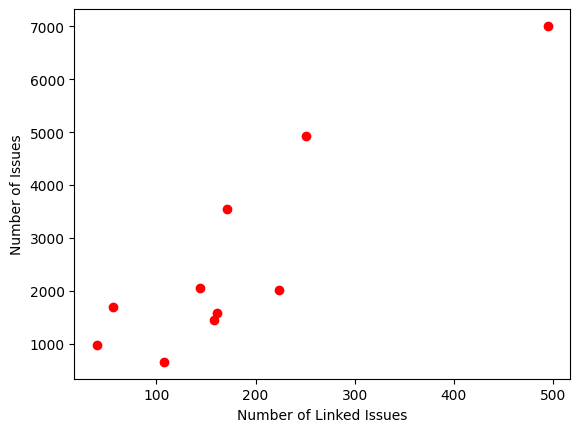

In [6]:

import matplotlib.pyplot as plt

plt.plot( yLinkedIssue,zNumIssues, 'ro')
plt.ylabel('Number of Issues')
plt.xlabel('Number of Linked Issues')
plt.show()

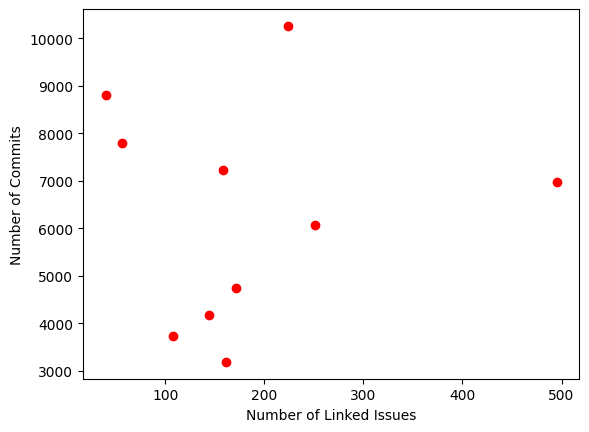

In [7]:
plt.plot( yLinkedIssue, xNumCommits,'ro')
plt.ylabel('Number of Commits')
plt.xlabel('Number of Linked Issues')
plt.show()